In [1]:
import h5py

import numpy as np 
import pandas as pd 
import scipy as sp 
import matplotlib.pyplot as plt

rng = np.random.default_rng()

## 1) Generating the self avoiding walk

In [2]:
def initial_config(N):
    """Generates a self avoiding inital config with: 
        dimension of grid d and length N"""
    # Generate walk as a straight line in x-direction 
    # A walk of length N has N+1 points
    x = np.arange(0,N+1, dtype=int)
    y = np.zeros((N+1,1), dtype=int)
    # Concatenation along the second axis 
    walk = np.c_[x,y]
    return walk

def transformation_matrix():
    """Generates a transformation matrix (rotation or reflection) for a 2 dimensional square lattice"""
    rotations_list = [np.array([[0,-1],[1,0]]), np.array([[-1,0],[0,-1]]), np.array([[0,1],[-1,0]])]
    reflections_list = [np.array([[1,0],[0,-1]]), np.array([[0,1],[1,0]]), np.array([[-1,0],[0,1]]), np.array([[0,-1],[-1,0]])]
    transformations_list = rotations_list + reflections_list
    return transformations_list[rng.integers(0,len(transformations_list))]

In [3]:
def sample_pivot(walk): 
    """Proposes a walk by splitting the walk at pivot location in two parts (conserved and changing), 
    Performing matrix multiplication on the changing part of the walk.""" 
    # Generate a random pivot location and transformation matrix 
    location = rng.integers(0, len(walk)-1)
    matrix = transformation_matrix() 

    # Split chain based on pivot location
    conserved_chain = walk[:location+1]
    changing_chain = walk[location+1:] 
     
    # Define origin of rotaion/reflection
    origin = conserved_chain[-1]
    
    # Apply rotation/reflection matrix to changing part of the walk - shift origin of transformation from (0,0) to pivot location
    new_chain = [origin + np.matmul(matrix, np.transpose(i - origin)) for i in changing_chain]
    proposed_walk = np.append(conserved_chain, new_chain, axis=0)

    return proposed_walk 

def acceptance(walk):
    """Checks if the walk is self avoiding by checking if there are only unique coordinates in the walk"""
    # Make a list of all unique elements (coordintates) in walk
    unique_elements = np.unique(walk, axis=0)
    if len(unique_elements) == len(walk): 
        return True
    else: 
        return False


In [4]:
def markov_chain_pivot(walk, m): 
    """Markov chain simulation for m accepted markov-steps - returns a new walk"""
    # Count number of accepted pivots
    step = 0
    while step < m: 
        # Sample a walk
        sample = sample_pivot(walk) 
        # Check if walk is accepted
        if acceptance(sample) == True: 
            # Add to steps and change walk 
            step = step + 1
            walk = sample 
    return walk

def end_to_end_distance(walk): 
    """Computes Euclidian distance between begin and end of the walk"""
    return np.linalg.norm(walk[0] - walk[-1])

def batch_estimate(data,observable,k):
    """Devide data into k batches and apply the function observable to each.
    Returns the mean and standard error."""
    batches = np.reshape(data,(k,-1))
    values = np.apply_along_axis(observable, 1, batches)
    return np.mean(values), np.std(values)/np.sqrt(k-1)

In [5]:
def plot_walk(walk):
    """ Plot the walk on a 2D grid"""
    x = walk[:,0]
    y = walk[:,1]
    
    plt.figure(figsize = (5, 5))
   
    plt.plot(x, y, '-o',  linewidth = 1)
    plt.plot(0, 0, 'go', ms = 10, label = 'Start')
    plt.plot(x[-1], y[-1], 'ro', ms = 10, label = 'End')
    
    plt.axis('equal')
    plt.grid()
    plt.tick_params(labelbottom=False, labelleft=False)
    plt.xticks(np.arange(-len(walk), len(walk)+1, 1))
    plt.yticks(np.arange(-len(walk), len(walk)+1,1))

    plt.legend(fontsize=15)
    #plt.title('Self-avoiding walk', fontsize=14, fontweight='bold', y = 1.05)
    plt.show()

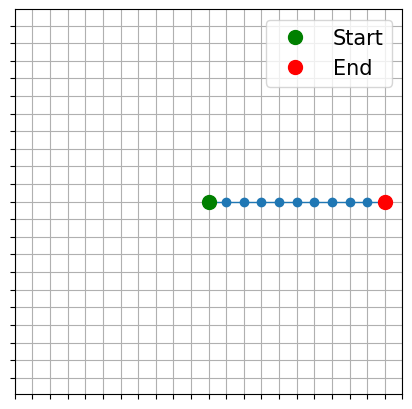

In [6]:
walk = initial_config(10)
plot_walk(walk)

## 2) Equilibration

### A) Based on the end-to-end distance -> Does not converge

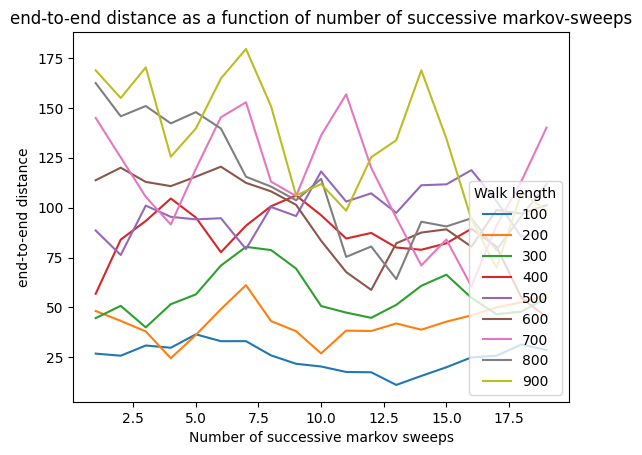

In [7]:
with h5py.File("end-to-end_distance_successive_sweeps.hdf5", 'a') as f:
    if not 'distances' in f:
        N_list = np.arange(100, 1000, 100)
        sweep_list = np.linspace(0,20,21) 
        all_distances = np.zeros((len(N_list), len(sweep_list)))

        for n in range (0, len(N_list)): 
            N = N_list[n]
            walk = initial_config(N)
            temp_distances = [] 

            for sweep in range (0, len(sweep_list)): 
                pivoted_walk = markov_chain_pivot(walk, N)
                temp_distances.append(end_to_end_distance(pivoted_walk))

                walk = pivoted_walk 

            all_distances[n] = temp_distances 
            
        f.create_dataset('distances', data = all_distances)
        f.create_dataset('length', data = N_list)
        f.create_dataset('sweeps', data = sweep_list) 
        

with h5py.File("end-to-end_distance_successive_sweeps.hdf5", 'r') as f:
    all_distances = f['distances'] 
    N_list = f['length']
    sweeps = f['sweeps']

    avg_list = np.zeros((len(N_list), len(sweeps)-2))
    for n in range (0, len(N_list)): 
        temp_list = []
        for j in range (1, len(sweeps)-1): 
            temp_list.append(np.mean([all_distances[n,j-1], all_distances[n,j], all_distances[n,j+1]]))
        avg_list[n] = temp_list 

        
        plt.plot(sweeps[1:-1], avg_list[n], label=N_list[n])
    plt.legend(title='Walk length', loc = 'lower right')
    plt.title('end-to-end distance as a function of number of successive markov-sweeps')
    plt.xlabel('Number of successive markov sweeps')
    plt.ylabel('end-to-end distance')
    plt.show()

Does not converge

### B) Based on amount of turns in the walk -> Converges after 3 to 5 successive sweeps 

In [8]:
def turn_fraction(walk):
    """ Computes the number of turns in a walk and returns the fraction of turns vs walk length"""
    turns = 0
    for i in range(len(walk)-2):
        if np.array_equal(abs(walk[i+2]-walk[i]), np.array([1,1])):
            turns += 1
    return turns/len(walk)

Number of equilibration sweeps needs to be based on the accepted states, such that the number of sweeps to reach the equilibrium state is the same for all walk lengths. Two figures follow, the first one is based on only accepted states. The second one is based on accepted and rejected states. 

with h5py.File("turn_fractions_successive_sweeps.hdf5", 'a') as f:
    if 'fractions' in f:
        del f['fractions'] 
        del f['length']
        del f['sweeps']


In [9]:
import time 

[0.47808765 0.51792829 0.57370518 0.57370518 0.60159363 0.62549801
 0.56972112 0.58565737 0.56175299 0.60956175 0.65338645 0.61752988
 0.62151394 0.58964143 0.62549801 0.60159363 0.59760956 0.57768924
 0.5936255  0.61354582 0.56972112]
[ 250  500 1000 2500]
250


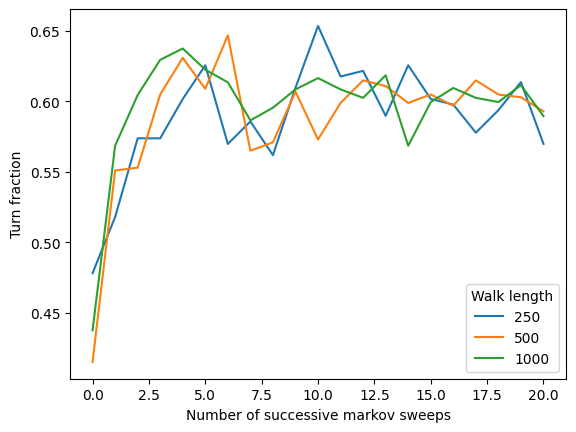

In [10]:
with h5py.File("turn_fractions_successive_sweeps.hdf5", 'a') as f:
    if not 'fractions' in f:
        N_list = np.array([250, 500, 1000, 2500])
        sweep_list = np.linspace(0,20,21) 
        all_fractions = np.zeros((len(N_list), len(sweep_list)))

        for n in range (0, len(N_list)): 
            N = N_list[n]
            print(N)
            walk = initial_config(N)
            temp_fractions = [] 

            for sweep in range (0, len(sweep_list)): 
                print(sweep)
                print(time.asctime())
                pivoted_walk = markov_chain_pivot(walk, N)
                temp_fractions.append(turn_fraction(pivoted_walk))

                walk = pivoted_walk 

            all_fractions[n] = temp_fractions 
            
        f.create_dataset('fractions', data = all_fractions)
        f.create_dataset('length', data = N_list)
        f.create_dataset('sweeps', data = sweep_list) 
        

with h5py.File("turn_fractions_successive_sweeps.hdf5", 'r') as f:
    all_fractions = f['fractions'] 
    print(all_fractions[0])
    N_list = np.array([250, 500, 1000, 2500])
    print(N_list)
    
    sweeps = f['sweeps']
    print(N_list[0])

    for i in range (0, len(N_list)-1):
        plt.plot(sweeps[:], all_fractions[i,:], label=N_list[i])
    plt.legend(title='Walk length', loc = 'lower right')
    #plt.title('Turn fraction as a function of number of successive markov-sweeps')
    plt.xlabel('Number of successive markov sweeps')
    plt.ylabel('Turn fraction')
    plt.show()

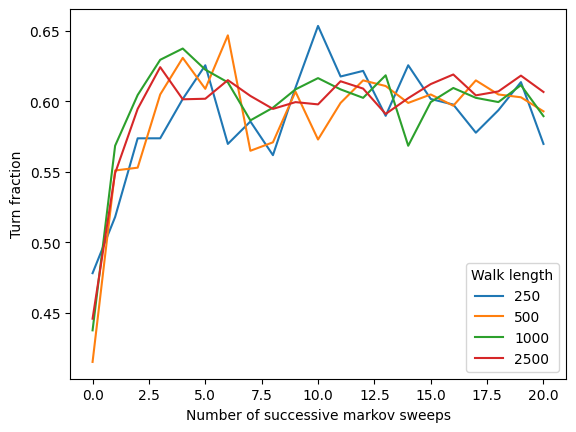

In [11]:
with h5py.File("turn_fractions_successive_sweeps.hdf5", 'r') as f:
    all_fractions = f['fractions'] 
    N_list = np.array([250, 500, 1000, 2500])
    sweeps = f['sweeps']

    for i in range (0, len(N_list)):
        plt.plot(sweeps[:], all_fractions[i], label=N_list[i])
    plt.legend(title='Walk length', loc = 'lower right')
    #plt.title('Turn fraction as a function of number of successive markov-sweeps')
    plt.xlabel('Number of successive markov sweeps')
    plt.ylabel('Turn fraction')
    plt.savefig('EQ_turn_fraction')
    plt.show()

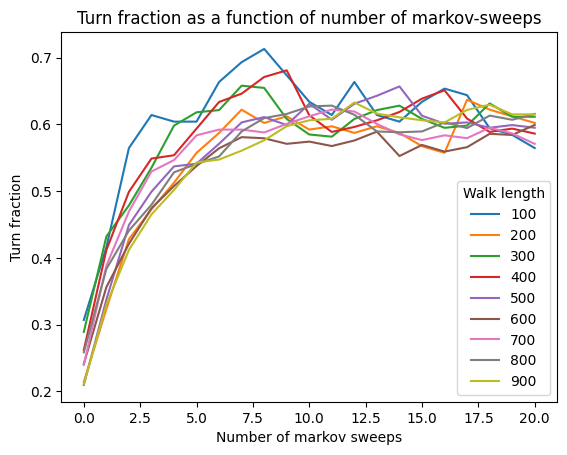

In [12]:
with h5py.File("turn_fractions_sweeps.hdf5", 'a') as f:
    if not 'fractions' in f:
        N_list = np.arange(100, 1000, 100)
        sweep_list = np.linspace(0,20,21) 
        all_fractions = np.zeros((len(N_list), len(sweep_list)))

        for n in range (0, len(N_list)): 
            N = N_list[n]
            walk = initial_config(N)
            temp_fractions = [] 

            for sweep in range (0, len(sweep_list)): 
                pivoted_walk = markov_chain_pivot(walk, N)
                temp_fractions.append(turn_fraction(pivoted_walk))

                walk = pivoted_walk 

            all_fractions[n] = temp_fractions 
            
        f.create_dataset('fractions', data = all_fractions)
        f.create_dataset('length', data = N_list)
        f.create_dataset('sweeps', data = sweep_list) 
        

with h5py.File("turn_fractions_sweeps.hdf5", 'r') as f:
    all_fractions = f['fractions'] 
    N_list = f['length']
    sweeps = f['sweeps']

    for i in range (0, len(N_list)):
        plt.plot(sweeps[:], all_fractions[i], label=N_list[i])
    plt.legend(title='Walk length')
    plt.title('Turn fraction as a function of number of markov-sweeps')
    plt.xlabel('Number of markov sweeps')
    plt.ylabel('Turn fraction')
    plt.show()

Based on only successive markov sweeps, the number of equilibrium sweeps is around 3. We can overestimate this by choosing 5. </br> 
Based on accepted and rejected markov sweeps, the number of equilibrium sweeps is arount 10. We can overestimate this by choosing 15. 

### C) Based on the length of the longest straight part of the walk

In [13]:
def changes_direction(walk):
    """Returns the locations at which the walk makes a turn"""
    loc_changes = [] 
    for i in range (len(walk)-2): 
        if np.array_equal(abs(walk[i+2]-walk[i]), np.array([1,1])):
            loc_changes.append(i+1)
    return loc_changes

def longest_part(walk): 
    """Returns the length of the longest straight part of the walk"""
    differences = np.diff(changes_direction(walk), n=1) 
    return differences.max()

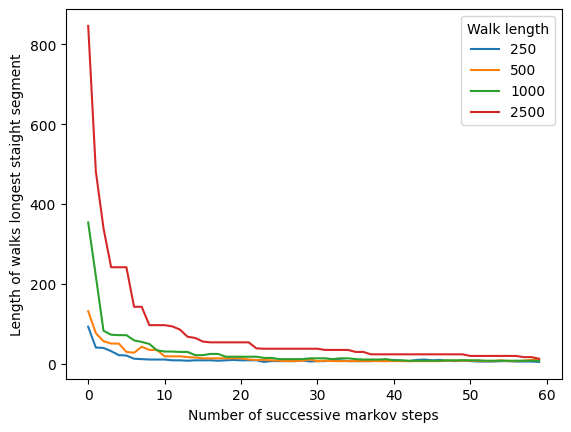

In [14]:
with h5py.File("longest_walk_parts_successive_steps.hdf5", 'a') as f:
    if not 'longest_parts' in f:
        N_list = np.array([250, 500, 1000, 2500])
        sweep_list = np.linspace(0,20,21) 
        longest_parts = np.zeros((len(N_list), 90))

        for n in range (0, len(N_list)): 
            N = N_list[n]
            walk = initial_config(N)
            temp_longest = [] 
            for measurement in range (10, 100):
                print(measurement)
                print(time.asctime())
                pivoted_walk = markov_chain_pivot(walk, measurement)
                temp_longest.append(longest_part(pivoted_walk))

                walk = pivoted_walk 

            longest_parts[n] = temp_longest 
            
        f.create_dataset('longest_parts', data = longest_parts)
        f.create_dataset('length', data = N_list)
        f.create_dataset('sweeps', data = sweep_list) 
        

with h5py.File("longest_walk_parts_successive_steps.hdf5", 'r') as f:
    longest_parts = f['longest_parts']
    N_list = f['length']
    sweeps = f['sweeps']
    measurements = np.arange(0,90) 
    for i in range (0, len(N_list)):
        walk_length = N_list[i]
        plt.plot(measurements[:60], longest_parts[i][:60], label=walk_length)
    plt.legend(title='Walk length', loc = 'upper right')
    #plt.title('Length of longest straight piece of walk a function of number of successive markov-sweeps')
    plt.xlabel('Number of successive markov steps')
    plt.ylabel('Length of walks longest staight segment')
    plt.savefig('EQ_longest_segment')
    plt.show()

### D) Difference in equilibration between starting at a uniform state or starting at a state with many angles

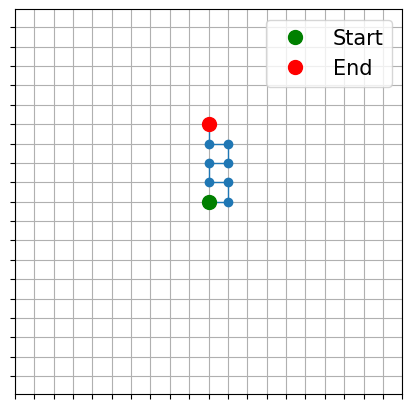

In [15]:
def noise_walk(N): 
    x_coords = np.zeros(N)
    for i in range (1,len(x_coords)-1,4): 
        x_coords[i] = 1 
        x_coords[i+1] = 1
    
    y_coords = np.zeros(N)
    counter = 0
    for i in range (0,len(y_coords),2):
        y_coords[i] = counter
        y_coords[i+1] = counter
        counter = counter + 1

    walk = np.c_[x_coords, y_coords]
    return walk
    
plot_walk(noise_walk(10))

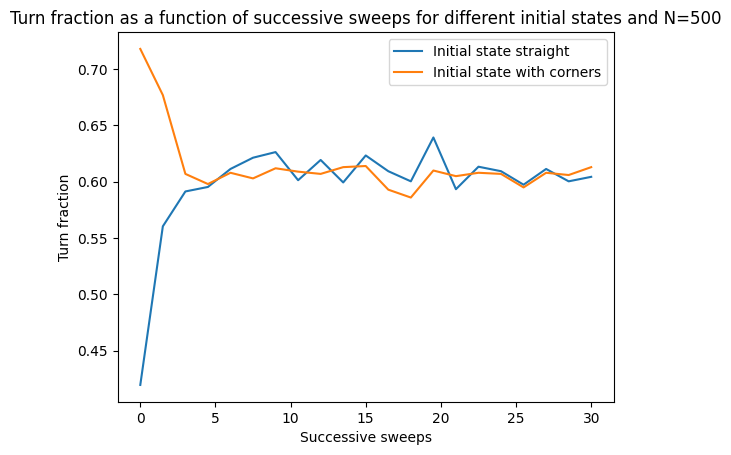

In [16]:
N = 1000
sweep_list = np.linspace(0,30,21) 
all_fractions = np.zeros(len(sweep_list))

straight_walk = initial_config(N)
random_walk = noise_walk(N) 

temp_straight_fractions = [] 
temp_random_fractions = [] 

for sweep in range (0, len(sweep_list)): 
    pivoted_straight_walk = markov_chain_pivot(straight_walk, N)
    pivoted_random_walk = markov_chain_pivot(random_walk, N) 
    temp_straight_fractions.append(turn_fraction(pivoted_straight_walk))
    temp_random_fractions.append(turn_fraction(pivoted_random_walk))

    straight_walk = pivoted_straight_walk
    random_walk = pivoted_random_walk

plt.plot(sweep_list, temp_straight_fractions, label='Initial state straight')
plt.plot(sweep_list, temp_random_fractions, label='Initial state with corners')
plt.title('Turn fraction as a function of successive sweeps for different initial states and N=500')
plt.xlabel('Successive sweeps') 
plt.ylabel('Turn fraction') 
plt.savefig('EQ_compare')
plt.legend()
plt.show()

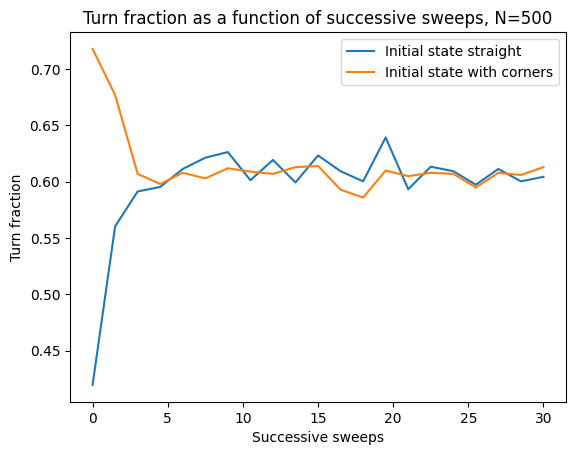

In [17]:
plt.plot(sweep_list, temp_straight_fractions, label='Initial state straight')
plt.plot(sweep_list, temp_random_fractions, label='Initial state with corners')
plt.title('Turn fraction as a function of successive sweeps, N=500')
plt.xlabel('Successive sweeps') 
plt.ylabel('Turn fraction') 
plt.savefig('EQ_compare')
plt.legend()
plt.show()

Het aantal equilibrium sweeps zit ongeveer rond de 5 sweeps. We zouden het iets kunnen overschatten voor de zekerheid en voor 10 sweeps kunnen gaan.

## 3) Autocorrelation 

In [18]:
def sample_autocovariance(x,tmax):
    '''Compute the sample autocorrelation of the time series x 
    for t = 0,1,...,tmax-1.'''
    x_shifted = x - np.mean(x)
    return np.array([np.dot(x_shifted[:len(x)-t],x_shifted[t:])/(len(x)-t) 
                     for t in range(tmax)])

def find_correlation_time(autocov):
    '''Return the index of the first entry that is smaller than autocov[0]/e or the length of autocov if none are smaller.'''
    smaller = np.where(autocov < np.exp(-1)*autocov[0])[0]
    return smaller[0] if len(smaller) > 0 else len(autocov)

In [19]:
def estimate_autocorrelation_time(N, eq, n, tmax):
    """Estimate the autocorrelation time using eq sweeps, calculating the autocovariance up to t=tmax <n """
    walk = initial_config(N)
    
    # Equilibration 
    walk = markov_chain_pivot(walk, eq*N) 
    return find_correlation_time(sample_autocovariance(markov_chain_pivot(walk, n)[:,0],tmax)) 

for N=  100 , autocorrelation time = 3
for N=  200 , autocorrelation time = 2
for N=  300 , autocorrelation time = 2
for N=  400 , autocorrelation time = 3


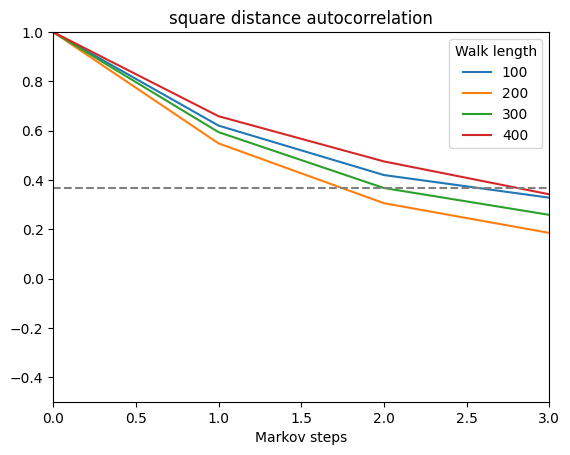

In [20]:
N_array = np.arange(100,500,100)
for N in N_array:
    tmax = 5*N
    markov_chain = []
    walk = initial_config(N)

    #Equilibration 
    walk = markov_chain_pivot(walk, 20*N)
    for _ in range(tmax):
        walk = markov_chain_pivot(walk,1)
        markov_chain.append(end_to_end_distance(walk))
        
    autocov = sample_autocovariance(markov_chain,tmax)
    autocorr_time = find_correlation_time(autocov)
    print("for N= ", N, ", autocorrelation time =",autocorr_time)
    plt.plot(np.arange(tmax), autocov/autocov[0], label=N)
plt.axhline(np.exp(-1),linestyle='--',color='0.5')
plt.xlabel("Markov steps")
plt.title("square distance autocorrelation")
plt.ylim(-0.5,1)
plt.xlim(0,3)
plt.legend(title="Walk length")



for N=  100 , autocorrelation time = 4
for N=  500 , autocorrelation time = 3
for N=  1000 , autocorrelation time = 3
for N=  2500 , autocorrelation time = 3


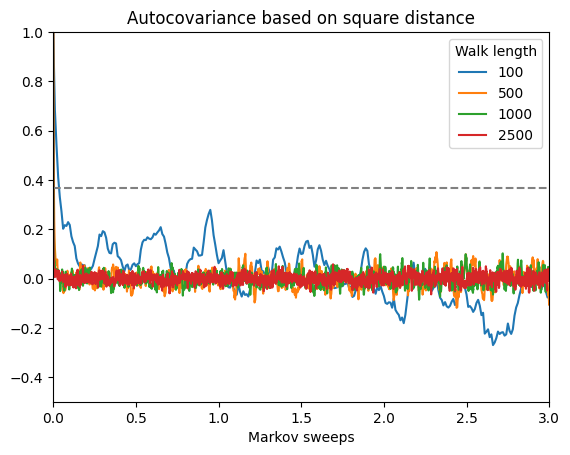

In [25]:
N_array = np.array([100, 500, 1000, 2500])
autocov_dict = dict()

for N in N_array:
    tmax = 5*N
    markov_chain = []
    walk = initial_config(N)
    
    walk = markov_chain_pivot(walk, 20*N)
    for _ in range(tmax):
        walk = markov_chain_pivot(walk,1)
        markov_chain.append(end_to_end_distance(walk))
        
    autocov = sample_autocovariance(markov_chain,tmax)
    autocorr_time = find_correlation_time(autocov)
    print("for N= ", N, ", autocorrelation time =",autocorr_time)

    autocov_dict[N] = autocov
    plot = plt.plot(np.arange(tmax)/N, autocov/autocov[0], label=N)
    #plot_list.append(plot)
plt.axhline(np.exp(-1),linestyle='--',color='0.5')
plt.xlabel("Markov sweeps")
plt.title("Autocovariance based on square distance")
plt.ylim(-0.5,1)
plt.xlim(0,3)
plt.savefig('Autocorrelation_large')
plt.legend(title="Walk length")

De autocorrelation time zit ergens tussen de 0.1 en 0.25 sweeps. Ik heb gekozen nu voor 0.5 in de .py file om te kijken of dat werkt.

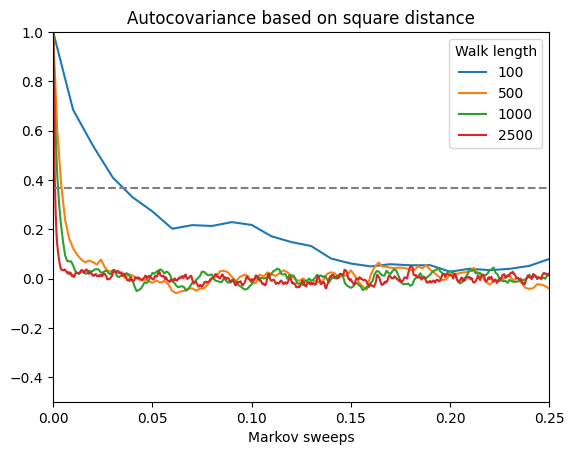

In [27]:
for N in N_array:
    tmax = 5*N
    autocov = autocov_dict[N]
    plt.plot(np.arange(tmax)/N, autocov/autocov[0], label=N)
plt.axhline(np.exp(-1),linestyle='--',color='0.5')
plt.xlabel("Markov sweeps")
plt.title("Autocovariance based on square distance")
plt.ylim(-0.5,1)
plt.xlim(0,0.25)
plt.savefig('Autocorrelation_small')
plt.legend(title="Walk length")

De autocorrelation time is below 0.1 Markov sweeps for all shown walk lengths.